In [1]:
import numpy as np
import scipy as sp
import torch
from pytorch_unet import UNet

import girder_client
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime

### Note
Girder stuff is only needed once to download files

In [2]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"/home/nick/dev/SaggitalSpineSegmentation_Data"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

ultrasound_size = 128
num_classes = 2
num_epochs = 500
batch_size = 128
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 10
WCE_weights = np.array([0.1, 0.9])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_validation_rounds = -1

# Uncomment for faster debugging

roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
limit_validation_rounds = 1
num_epochs = 1

Save timestamp: 2021-08-05_11-48-42


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

In [4]:
data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

In [5]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    
    segmentation_data = np.load(segmentation_fullname)
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))


Total time to load from files: 0:00:00.068187


In [6]:
np.shape(ultrasound_arrays[0])

(523, 128, 128, 1)

In [7]:
ultrasound_arrays[0].dtype

dtype('float16')

In [8]:
print(np.max(ultrasound_arrays[0]), np.min(ultrasound_arrays[0]))

1.0 0.0


In [9]:
np.shape(segmentation_arrays[0])

(523, 128, 128, 1)

In [10]:
segmentation_arrays[0].dtype

dtype('uint8')

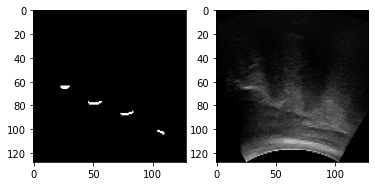

In [11]:
plt.subplot(1,2,1)
plt.imshow(segmentation_arrays[0][0][:,:,0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.asarray(ultrasound_arrays[0][0][:,:,0], dtype = np.float32), cmap='gray')

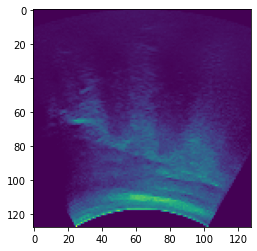

In [12]:
plt.imshow(np.asarray(ultrasound_arrays[0][0][:,:,0], dtype = np.float32))

In [13]:
for i in range(n_files):
    print(np.shape(ultrasound_arrays[i]))

(523, 128, 128, 1)
(355, 128, 128, 1)
(477, 128, 128, 1)
(453, 128, 128, 1)
(289, 128, 128, 1)
(387, 128, 128, 1)
(360, 128, 128, 1)
(446, 128, 128, 1)


### Notes
- US images are upside-down
- Images are in channels-last format, need channels-first
- US images are dtype float16, segmentations are uint8
- Each of the 8 patient datasets have a different number of images

In [14]:
x_set = ultrasound_arrays[0]
y_set = segmentation_arrays[0]

x_set = torch.tensor(x_set, dtype=torch.float32)
y_set = torch.tensor(y_set)

x_set = torch.permute(x_set, (0,3,1,2))
y_set = torch.permute(y_set, (0,3,1,2))

print(x_set.size(), y_set.size())
# x_set = np.squeeze(x_set, axis=2)

print(x_set.dtype)

torch.Size([523, 1, 128, 128]) torch.Size([523, 1, 128, 128])
torch.float32


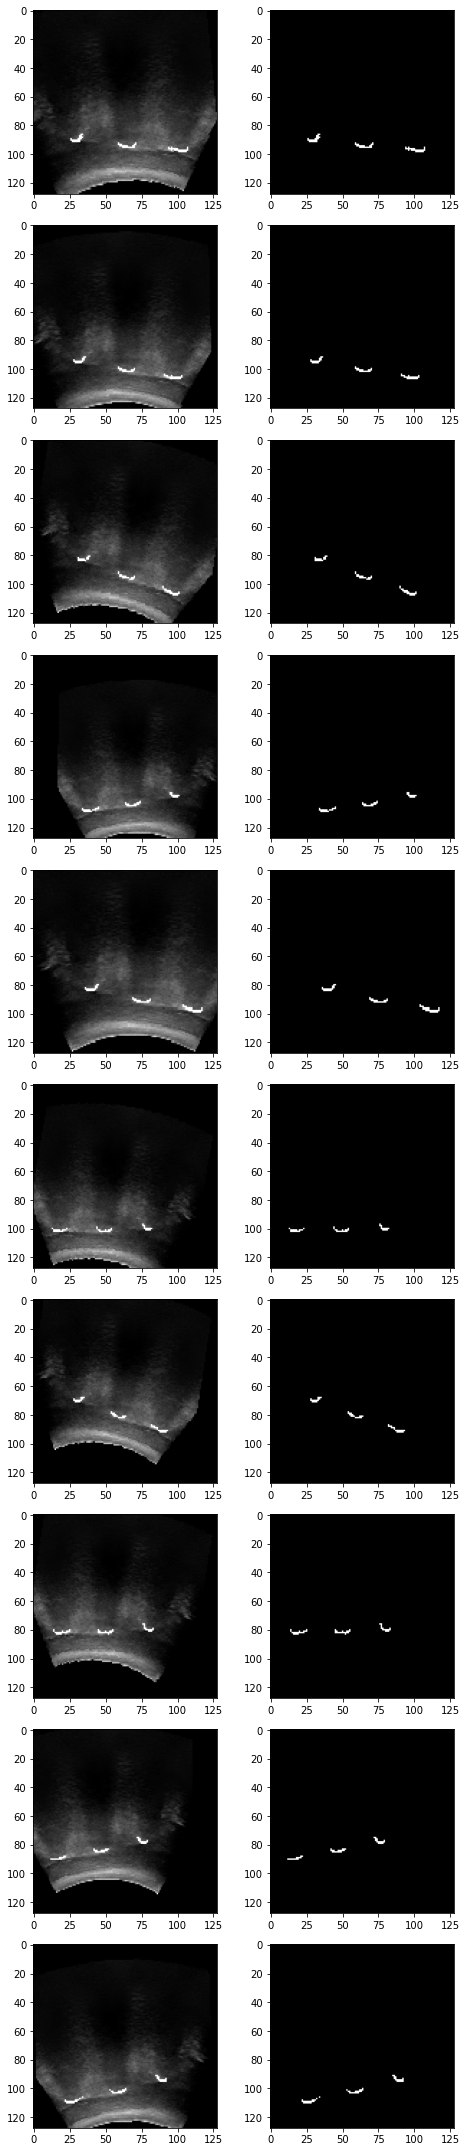

In [15]:
# Try the data generator

from matplotlib.pyplot import figure
from dataset_loader import DataAugmentor

dataset = DataAugmentor(x_set, y_set, image_dimensions = (128,128))

n = 10
fig = plt.figure(figsize=(7, n*3))
for i in range(n):
    usimg, seg = dataset.__getitem__(15)
    usimg = usimg.squeeze(0)
    seg = seg.squeeze(0)
    usimg[seg == 1] = 1
    
    a0 = fig.add_subplot(n,2,i*2+1)
    im0 = a0.imshow(usimg, cmap='gray')
    a1 = fig.add_subplot(n,2,i*2+2)
    im1 = a1.imshow(seg, cmap='gray')

fig.tight_layout()

In [16]:
assert False

AssertionError: 

In [ ]:
# try a batch generator

train_gen = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=4)

iter_cap = 1
step = 0 
for inputs, targets in train_gen:
    print(inputs.size(), targets.size())
    
    plt.imshow(inputs[0].squeeze(0))
    
    if step < iter_cap:
        break
    else:
        step += 1